In [25]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from time import perf_counter
from particle_filter import filter
from functools import partial
from scipy.stats import multivariate_normal
from pmcmc import PMCMC

In [26]:
rng = np.random.default_rng(0)

In [27]:
'''Testing PMCMC on the movement model Ye designed which is derived from the approach in the Pei paper. '''


def gen_movement(rng,population,min=0.03, max=0.08, Mov=1, Chain=1):
    '''Generates a random movement matrix for testing the simulation, chain controls whether the movement is seqential between nodes. '''
    movement = np.zeros((len(population), len(population)))
    if Mov==1:
        for i in range(len(population)):
            for j in range(len(population)):
                movement[i][j] = rng.integers(min * population[j], max * population[j])
        np.fill_diagonal(movement, 0)
        #if Chain==1, only allow movement from i to i+1, everything else is 0
    if Chain==1:
        movement = np.zeros((len(population), len(population)))
        for i in range(1,len(population)):
            movement[i][i-1] = rng.integers(min * population[i-1], max * population[i-1])

            
    return movement

In [28]:
'''We start each time step by running the tau leaping algorithm on our
day time population. The day time tau leap is moving compartments to different locations.
We assume that the time clock starts at 8am in the morning. We run the tau leap for 1/3 of the day, 
and then we run the night time tau leap for 2/3 of the day.'''
tau_day = 1 / 3 # Time step for daytime tau leap
tau_night = 2 / 3 # Time step for night time tau leap   

@njit
def movers_calc(S,I, mov_ratio):
    '''Performs matrix algebra to compute the number of movers in both the S and I compartments and their destination
    if mov_ratio is a nxn matrix and S,I nx1 vectors then mov_S and mov_I are nxn matrices of movers. 
    '''
    mov_S = mov_ratio@np.diag(S)
    mov_I = mov_ratio@np.diag(I)
    return mov_S, mov_I

@njit
def mover_infection(movement,mov_S, mov_I, beta, tau_day):
    '''Calculates the rate of flux from S to I for movers. 
    Elementwise division and NaNs are handled in np.where'''
    mov_SI= (mov_I * mov_S)/movement

    mov_SI = np.where(~np.isfinite(mov_SI),0,mov_SI)
    #tau leap for the day time movement infection force

    return np.diag(beta)@mov_SI*tau_day



def SIR_tau_leap(rng, population, movement, initial_cond, theta):
    '''Runs a single iteration of tau leaping on a '''

    n = len(population)
    #initialize the result array
    result = np.zeros((n,3,2))
    result[:,:,0] = initial_cond   

    mov_ratio = movement@np.linalg.inv(np.diag(population))

    #start the tau leap for the day time
    #separate the movers in S,I,R compartments with movement matrix
    #simulate the trsmission among movers
    #first compute the in movement of people in each compartment

    mov_S,mov_I = movers_calc(result[:,0,0],result[:,1,0],mov_ratio)

    #then compute the transmitted people from S to I
    #with the transmission rate being beta_i, which is the destination of the movement
    #movement is the total population movement

    #tau leap for the day time movement infection force

    transfer_SI = rng.poisson(mover_infection(movement, mov_S, mov_I, theta[:n], tau_day))

    # #update the S,I,R compartments with the local transmission rate
    # #extract the S,I,R compartments
    # #subtract the movers
    # #last term mov_ratio@result[:,0,i-1] records the number of sus/infected people that are moving in the destination location
    S = result[:,0,0]-np.sum(mov_S, axis=0).T + mov_ratio@result[:,0,0] 
    I = result[:,1,0]-np.sum(mov_I, axis=0).T + mov_ratio@result[:,1,0] 
    R = result[:,2,0]
    
    #generate a poisson random number for each time step
    force_of_infection = rng.poisson(tau_day*theta[:n]*S*I/population)
    result[:,0,1] = S - force_of_infection
    #recover rate is 0.2 per day
    force_of_recovery = rng.poisson(theta[-1]*I*tau_day)
    result[:,1,1] = I + force_of_infection - force_of_recovery
    result[:,2,1] = R + force_of_recovery

    #start the tau leap for the night time
    #add the newly infected people back to their home location
    result[:,0,1]=result[:,0,1]+np.sum(mov_S, axis=0).T - np.sum(transfer_SI, axis=0).T - mov_ratio@result[:,0,0] 
    result[:,1,1]=result[:,1,1]+np.sum(mov_I, axis=0).T + np.sum(transfer_SI, axis=0).T - mov_ratio@result[:,1,0] 
    #find the negative values in ressult[:,1,i]
    #The reason for the negative values is that the force of infection is too high
    #find the index of the negative values in S
    neg_index_S = np.where(result[:,0,1]<0)
    #if neg_index_S is not empty
    if neg_index_S[0].size != 0:
        #save the negative values
        neg_value_S = result[neg_index_S,0,1]
        #set the negative values to 0
        result[neg_index_S,0,1] = 0
        #add the negative values to the infected compartment
        result[neg_index_S,1,1] = result[neg_index_S,1,1] + neg_value_S

    #find the index of the negative values in I 
    neg_index_I = np.where(result[:,1,1]<0)
    #if neg_index is not empty
    if neg_index_I[0].size != 0: 

        #save the negative values
        neg_valu_I = result[neg_index_I,1,1]
        #set the negative values to 0
        result[neg_index_I,1,1] = 0
        #add the negative values to the recovered compartment
        result[neg_index_I,2,1] = result[neg_index_I,2,1] + neg_valu_I 
    #update the S,I,R compartments with the local transmission rate
    #extract the S,I,R compartments
    S = result[:,0,1]
    I = result[:,1,1]
    R = result[:,2,1]
    #generate a poisson random number for each time step
    force_of_infection = rng.poisson(tau_night*theta[:n]*S*I/population)
    result[:,0,1] = S - force_of_infection
    #recover rate is 0.2 per day
    force_of_recovery = rng.poisson(theta[-1]*I*tau_night)
    result[:,1,1] = I + force_of_infection - force_of_recovery
    result[:,2,1] = R + force_of_recovery

    #find the negative values in ressult[:,1,i]
    #The reason for the negative values is that the force of infection is too high
    #find the index of the negative values in S
    neg_index_S = np.where(result[:,0,1]<0)
    #if neg_index_S is not empty
    if neg_index_S[0].size != 0:
        #save the negative values
        neg_value_S = result[neg_index_S,0,1]
        #set the negative values to 0
        result[neg_index_S,0,1] = 0
        #add the negative values to the infected compartment
        result[neg_index_S,1,1] = result[neg_index_S,1,1] + neg_value_S

    #find the index of the negative values in I 
    neg_index_I = np.where(result[:,1,1]<0)
    #if neg_index is not empty
    if neg_index_I[0].size != 0: 

        #save the negative values
        neg_valu_I = result[neg_index_I,1,1]
        #set the negative values to 0
        result[neg_index_I,1,1] = 0
        #add the negative values to the recovered compartment
        result[neg_index_I,2,1] = result[neg_index_I,2,1] + neg_valu_I 
    
    return result

Population per location:  [500 200]


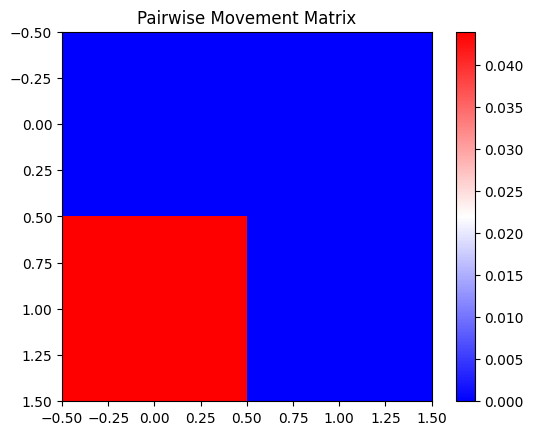

In [29]:
n=4
pop_test = np.array([500,200])
print("Population per location: ", pop_test)
mov_test = gen_movement(rng,pop_test,min=0.03, max=0.08, Mov=1, Chain=1)

#plot movement matrix as a heatmap
#add heat scale values
#do not scale the values
#let the largest value be dark red and the smallest value be dark blue
plt.title('Pairwise Movement Matrix')
plt.imshow(mov_test@np.linalg.inv(np.diag(pop_test)), cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

In [30]:
'''Modifying the code to support a particle distribution'''
n = 2

num_particles_sim = 1

particles_sim = np.zeros((num_particles_sim,6,60)) #First 4 S, second 4 I, third 4 R
particle_observations_sim = np.zeros((num_particles_sim,4,60))

particles_sim[:,0:2,0] = pop_test
particles_sim[:,2:4,0] = 5
particles_sim[:,0:2,0] -= particles_sim[:,2:4,0]

theta_test = np.array([0.4,0.1,0.05])

def movement_model(population, movement, particles,observations,t,dt,theta,rng,num_particles):

    for index,particle in enumerate(particles[:,:,t]):
        particles[index,:,t] = ((SIR_tau_leap(population=population, movement=movement, rng = rng, initial_cond=particle.reshape((3,len(pop_test))).T, theta = theta)[:,:,-1]).T).reshape(-1)
        observations[index,0:len(pop_test),t] = particles[index,len(pop_test):4,t]

    return particles,observations

model = partial(movement_model, pop_test, mov_test)

time = perf_counter()

for t in range(1,60):
    particles_sim[:,:,t] = particles_sim[:,:,t-1]
    particles_sim, particle_observations_sim = model(particles = particles_sim,observations=particle_observations_sim,t = t, dt = 1, rng = rng, num_particles=num_particles_sim, theta = theta_test)

print(f"Runtime for {num_particles_sim} particles was {perf_counter() - time} secs")

Runtime for 1 particles was 0.29416650000348454 secs


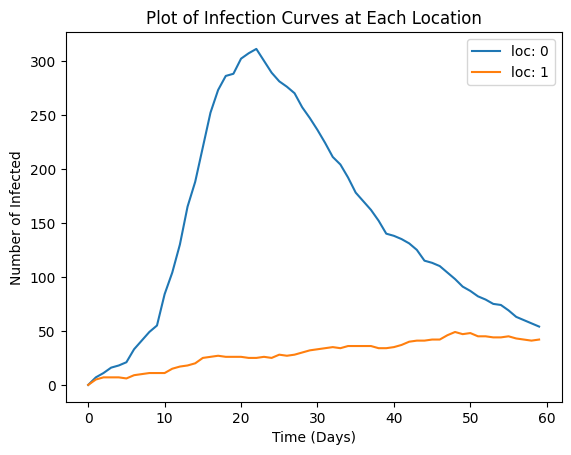

In [31]:
plt.title("Plot of Infection Curves at Each Location")
plt.xlabel('Time (Days)')
plt.ylabel("Number of Infected")
for loc in range(n):
    plt.plot(particle_observations_sim[:,loc,:].T,'-',label = f"loc: {loc}")
    #plot infected compartments for all locations together in one plot
    #add legend to the plot
    #add title to the plot
plt.legend()
plt.show()

In [32]:
@njit
def mm_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0:2] = np.array([500,200])

    particles_0[:,2:4] = rng.integers(1,10,size = (num_particles,2))
    particles_0[:,0:2] -= particles_0[:,2:4]
    

    return particles_0

def mm_obs(data_point, particle_observations, theta):
    weights = np.zeros(len(particle_observations))
    for p in range(len(weights)):
        weights[p] = multivariate_normal.logpdf(data_point, particle_observations[p,:],np.eye(len(data_point))) 
    return weights

In [33]:
data = particle_observations_sim[0,:,:].T #(node,T)
particles, particle_observations,weights,likelihood = filter(data = data, theta = theta_test, num_particles = 100, dt = 1., rng = rng, model = model,model_dim = 6,particle_init = mm_init,observation = mm_obs)

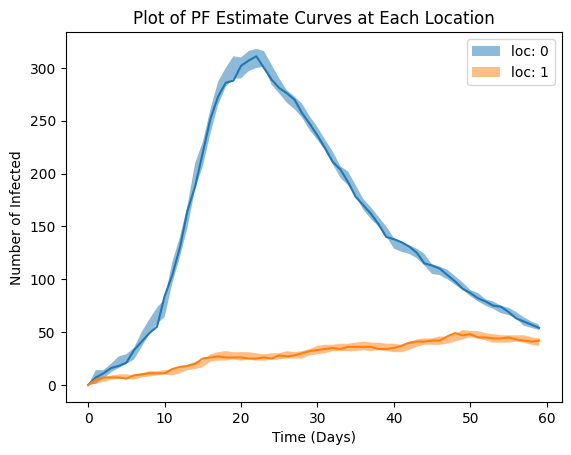

In [34]:
plt.title("Plot of PF Estimate Curves at Each Location")
plt.xlabel('Time (Days)')
plt.ylabel("Number of Infected")
for loc in range(n):
    plt.fill_between(np.arange(len(data)),np.percentile(particle_observations[:,loc,:].T,5,axis = 1),np.percentile(particle_observations[:,loc,:].T,95,axis = 1),alpha = 0.5,label = f"loc: {loc}")
    plt.plot(data[:,loc])
    #plot infected compartments for all locations together in one plot
    #add legend to the plot
    #add title to the plot
plt.legend()
plt.show()

In [35]:
@njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

In [36]:
@njit
def prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 0.,max_val= 1.) + \
        uniform_numba_logpdf(theta[1],min_val = 0.,max_val = 1.) + \
         uniform_numba_logpdf(theta[2],min_val = 0.,max_val = 0.5)

theta,LL,MLE_Particles,MLE_Observations = PMCMC(iterations = 1000, num_particles = 100, init_theta = np.array([0.1,0.1,0.01]), prior = prior, model = model, observation = mm_obs, data = data, rng = rng, dt = 1, model_dim = 6, particle_init = mm_init)

iteration: 10| Acceptance rate: 0.1| Log-Likelihood: -2326.1687516633924| Proposal [0.58427198 0.26189227 0.03897835]
iteration: 20| Acceptance rate: 0.1| Log-Likelihood: -420.54354139045324| Proposal [0.52819327 0.163438   0.04860293]
iteration: 30| Acceptance rate: 0.16666666666666666| Log-Likelihood: -411.04402038014865| Proposal [0.42055036 0.15513049 0.04645893]
iteration: 40| Acceptance rate: 0.15| Log-Likelihood: -400.7126808393488| Proposal [0.40439624 0.13431637 0.06218359]
iteration: 50| Acceptance rate: 0.16| Log-Likelihood: -396.9069116285075| Proposal [0.37458773 0.093146   0.04216155]
iteration: 60| Acceptance rate: 0.13333333333333333| Log-Likelihood: -396.9069116285075| Proposal [0.37458773 0.093146   0.04216155]
iteration: 70| Acceptance rate: 0.12857142857142856| Log-Likelihood: -395.58492561225336| Proposal [0.34556726 0.06352356 0.04796408]
iteration: 80| Acceptance rate: 0.1375| Log-Likelihood: -392.6039447645443| Proposal [0.3479281  0.07250757 0.04793134]
iterati

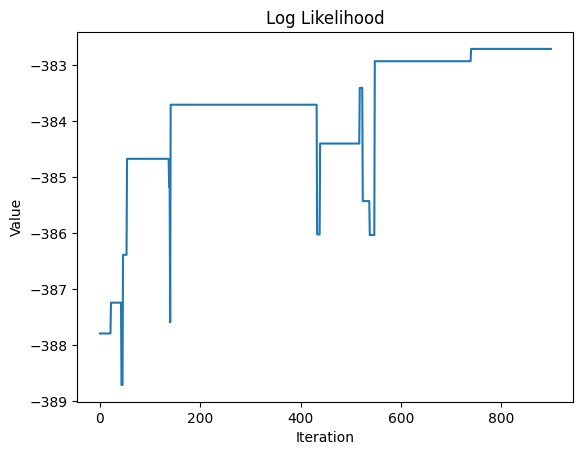

In [39]:
burn_in = 100

plt.title('Log Likelihood')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.plot(LL[burn_in:])

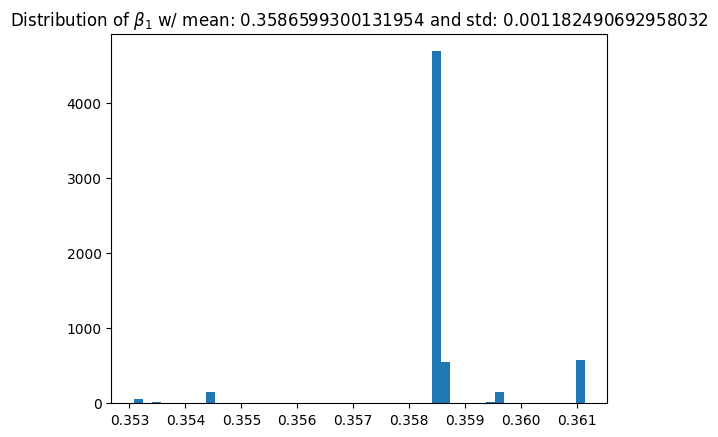

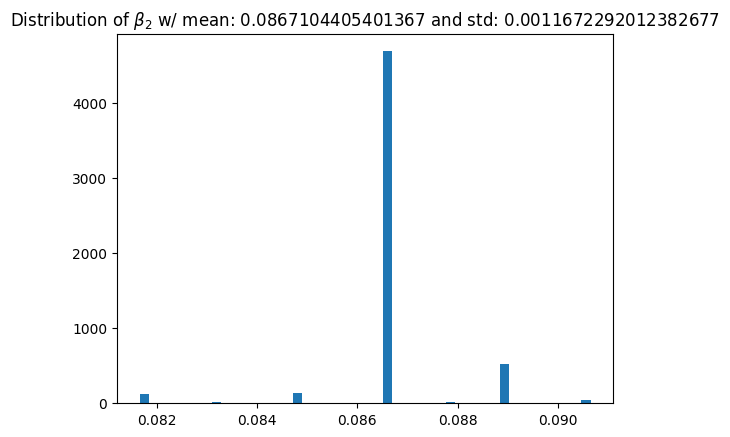

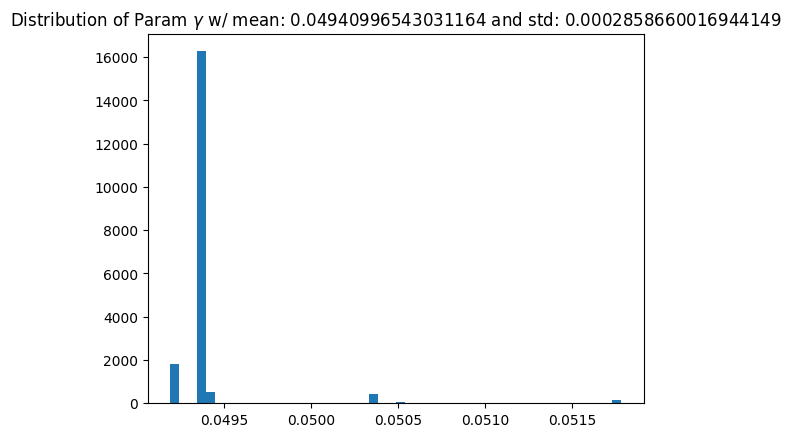

In [41]:
plt.title(f"Distribution of $\\beta_1$ w/ mean: {np.mean(theta[0,burn_in:])} and std: {np.std(theta[0,burn_in:])}")
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\beta_2$ w/ mean: {np.mean((theta[1,burn_in:]))} and std: {np.std((theta[1,burn_in:]))}")
plt.hist((theta[1,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of Param $\\gamma$ w/ mean: {np.mean(theta[2,burn_in:])} and std: {np.std(theta[2,burn_in:])}")
plt.hist(theta[2,burn_in:],density=True,bins = 50)
plt.show()
